In [1]:
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
import time
from os import listdir
from os.path import isfile, join
import random

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 20)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image


# Select GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

data_path = '/home/ubuntu/data/training/image/cifar10/'

print('Tensorflow version: ', tf.__version__)


Tensorflow version:  1.2.1


In [2]:
with open(data_path+'labels.txt') as f:
    categories = f.read().splitlines()
print(categories)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


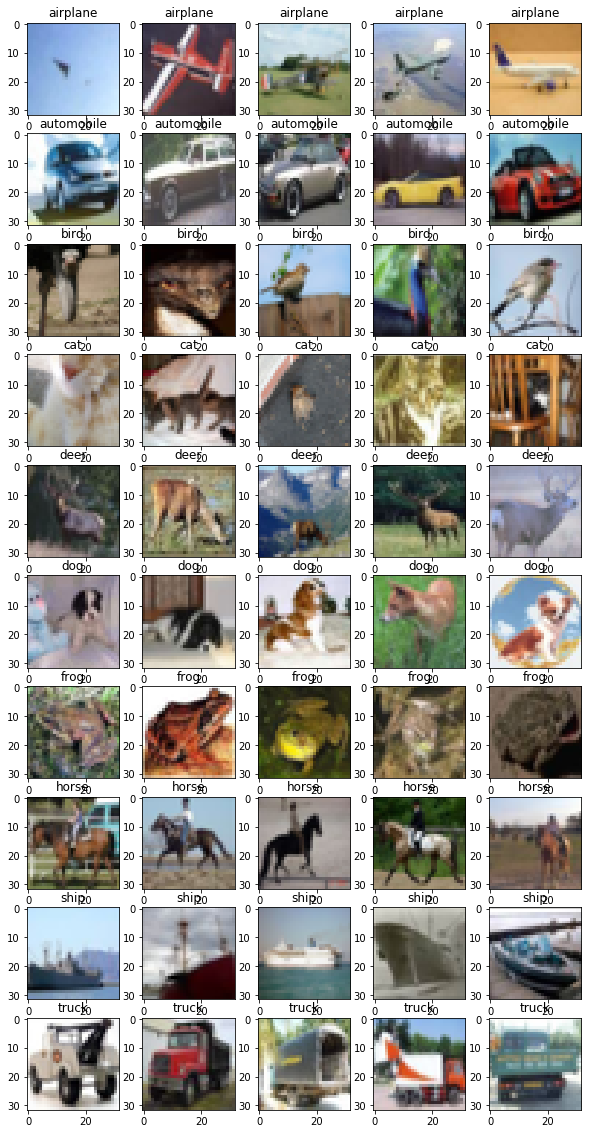

In [3]:
# Examine the data
fig = plt.figure()
n=0
for i, category in enumerate(categories):
    filelist = [f for f in listdir(join(data_path, 'train', category)) if isfile(join(data_path, 'train', category, f))]
    random.shuffle(filelist) # Randomize images
    for f in filelist[:5]: 
        n += 1
        a = fig.add_subplot(10,5,n)
        a.set_title(category)
        img = plt.imread(join(data_path, 'train', category, f))
        plt.imshow(img)
    

    

In [4]:
from tensorflow.contrib.keras import models, layers, optimizers, callbacks, preprocessing, regularizers


In [29]:
# Based on https://gist.github.com/JefferyRPrice/c1ecc3d67068c8d9b3120475baba1d7e

def residual_layer(input_tensor, nb_in_filters=64, nb_bottleneck_filters=16, filter_sz=3, stage=0, reg=0.0):

    bn_name = 'bn' + str(stage)
    conv_name = 'conv' + str(stage)
    relu_name = 'relu' + str(stage)
    merge_name = 'add' + str(stage)

    # batchnorm-relu-conv, from nb_in_filters to nb_bottleneck_filters via 1x1 conv
    if stage>1: # first activation is just after conv1
        x = layers.BatchNormalization(axis=1, name=bn_name+'a')(input_tensor)
        x = layers.Activation('relu', name=relu_name+'a')(x)
    else:
        x = input_tensor

    x = layers.Conv2D(nb_bottleneck_filters, (1, 1),
                      kernel_initializer='glorot_normal',
                      kernel_regularizer=regularizers.l2(reg),
                      use_bias=False,
                      name=conv_name+'a')(x)

    # batchnorm-relu-conv, from nb_bottleneck_filters to nb_bottleneck_filters via FxF conv
    x = layers.BatchNormalization(axis=1, name=bn_name+'b')(x)
    x = layers.Activation('relu', name=relu_name+'b')(x)
    x = layers.Conv2D(nb_bottleneck_filters, (filter_sz, filter_sz),
                      padding='same',
                      kernel_initializer='glorot_normal',
                      kernel_regularizer=regularizers.l2(reg),
                      use_bias = False,
                      name=conv_name+'b')(x)

    # batchnorm-relu-conv, from nb_in_filters to nb_bottleneck_filters via 1x1 conv
    x = layers.BatchNormalization(axis=1, name=bn_name+'c')(x)
    x = layers.Activation('relu', name=relu_name+'c')(x)
    x = layers.Conv2D(nb_in_filters, (1, 1),
                      kernel_initializer='glorot_normal',
                      kernel_regularizer=regularizers.l2(reg),
                      name=conv_name+'c')(x)

    # merge
    x = layers.add([x, input_tensor], name=merge_name)

    return x

In [32]:
#sz_ly0_filters, nb_ly0_filters, nb_ly0_stride = (128,3,2)
#sz_res_filters, nb_res_filters, nb_res_stages = (3,32,25)
# 92% of accuracy


sz_ly0_filters, nb_ly0_filters, nb_ly0_stride = (64,5,2)
sz_res_filters, nb_res_filters, nb_res_stages = (3,16,3)


  
    
img_input = layers.Input(shape=(32,32,3), name='cifar')

# Initial layers
x = layers.Conv2D(sz_ly0_filters, (nb_ly0_filters,nb_ly0_filters),
                  strides=(nb_ly0_stride, nb_ly0_stride), padding='same', 
                  kernel_initializer='glorot_normal',
                  kernel_regularizer=regularizers.l2(1.e-4),
                  use_bias=False, name='conv0')(img_input)

x = layers.BatchNormalization(axis=-1, name='bn0')(x)
x = layers.Activation('relu', name='relu0')(x)


# Resnet layers
for stage in range(1, nb_res_stages+1):
    x = residual_layer(x, nb_in_filters=64, nb_bottleneck_filters=nb_res_filters,
                       filter_sz=sz_res_filters, stage=stage,reg=0.0)

# Complete last resnet layer    
x = layers.BatchNormalization(axis=-1, name='bnF')(x)
x = layers.Activation('relu', name='reluF')(x)


# Final layer
x = layers.AveragePooling2D((16, 16), name='avg_pool')(x)
x = layers.Flatten(name='flat')(x)
x = layers.Dense(10, activation='softmax', name='fc1')(x)

model1 = models.Model(inputs=img_input, outputs=x)
model1.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cifar (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 16, 16, 64)        4800      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 16, 16, 64)        256       
_________________________________________________________________
relu0 (Activation)           (None, 16, 16, 64)        0         
_________________________________________________________________
conv1a (Conv2D)              (None, 16, 16, 16)        1024      
_________________________________________________________________
bn1b (BatchNormalization)    (None, 16, 16, 16)        64        
_________________________________________________________________
relu1b (Activation)          (None, 16, 16, 16)        0         
__________

In [34]:
my_datagen = preprocessing.image.ImageDataGenerator()

train_generator = my_datagen.flow_from_directory(
    join(data_path, 'train'),
    target_size=(32, 32),
    batch_size=50000)


test_generator = my_datagen.flow_from_directory(
    join(data_path, 'test'),
    target_size=(32, 32),
    batch_size=10000)


Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [40]:
X_train, y_train = next(train_generator)
X_test,  y_test  = next(test_generator)


In [41]:
# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

In [42]:
# Select optimizer and compile model
opt = optimizers.Adam()
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [ ]:
epochs = 50
batch_size = 32

tb_callback_ln = callbacks.TensorBoard(log_dir='/tmp/tensorboard/cifar10/resnet1')
history = model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                     validation_data=(X_test, y_test), callbacks=[tb_callback_ln])


Train on 50000 samples, validate on 10000 samples
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'float' object has no attribute 'name'
Epoch 1/50
50000/50000 [==============================] - 84s - loss: 1.6297 - acc: 0.4043 - val_loss: 1.8571 - val_acc: 0.3445
Epoch 2/50
50000/50000 [==============================] - 85s - loss: 1.3130 - acc: 0.5263 - val_loss: 1.4681 - val_acc: 0.4622
Epoch 3/50
50000/50000 [==============================] - 89s - loss: 1.1758 - acc: 0.5778 - val_loss: 1.1711 - val_acc: 0.5818
Epoch 4/50
50000/50000 [==============================] - 91s - loss: 1.0924 - acc: 0.6107 - val_loss: 1.1250 - val_acc: 0.5949
Epoch 5/50
50000/50000 [==============================] - 92s - loss: 1.0370 - acc: 0.6328 - val_loss: 1.2169 - val_acc: 0.5661
Epoch 6/50
50000/50000 [==============================] - 93s - loss: 0.9961 - acc: 0.6472 - val_loss: 1.1314 - val_acc: 0.5898
Epoch 7/50
50000/50000 [==============================]

In [1]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend(loc='lower right')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Save model



In [ ]:
# Test model




0.001

In [4]:


def batch_relu_conv(input_data, filters, kernel_size, strides=(1, 1)):
    out = layers.BatchNormalization()(input_data)
    conv1 = layers.Activation("relu")(out)        
    out = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', 
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(1.e-4))(out)
    return out
    

images = layers.Input(batch_shape=(None, 32, 32, 3), dtype='float32', name='Images')

conv1 = layers.Conv2D(64, (7,7), strides=(2, 2), padding='same', 
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(1.e-4))(images)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Activation("relu")(conv1)        
pool1 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)


block = pool1 
filters=64

res1_b1_c1 = layers.Conv2D(filters, (1,1), strides=(1, 1), padding='same', 
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(1.e-4))(block)
res1_b1_c2 = batch_relu_conv(res1_b1_c1, filters, (3,3))
res1_b1_c3 = batch_relu_conv(res1_b1_c2, filters*4, (1,1))
# Add residual
block_reshape = layers.Conv2D(filters*4, (1,1), strides=(1, 1), padding='same', 
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(1.e-4))(block)
res1_b1 = layers.add([block_reshape, res1_b1_c3])


block = res1_b1
res1_b2_c1 = batch_relu_conv(block, filters, (1,1))
res1_b2_c2 = batch_relu_conv(res1_b2_c1, filters, (3,3))
res1_b2_c3 = batch_relu_conv(res1_b2_c2, filters*4, (1,1))
block_reshape = layers.Conv2D(filters*4, (1,1), strides=(1, 1), padding='same', 
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(1.e-4))(block)
res1_b2 = layers.add([block_reshape, res1_b2_c3])



# Residual 2
filters= filters*2

block = res1_b2
res2_b1_c1 = batch_relu_conv(block, filters, (1,1), strides=(2, 2))
res2_b1_c2 = batch_relu_conv(res2_b1_c1, filters, (3,3))
res2_b1_c3 = batch_relu_conv(res2_b1_c2, filters*4, (1,1))
block_reshape = layers.Conv2D(filters*4, (1,1), strides=(2, 2), padding='same', 
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(1.e-4))(block)
res2_b1 = layers.add([block_reshape, res2_b1_c3])

block = res2_b1
res2_b2_c1 = batch_relu_conv(block, filters, (1,1))
res2_b2_c2 = batch_relu_conv(res2_b2_c1, filters, (3,3))
res2_b2_c3 = batch_relu_conv(res2_b2_c2, filters*4, (1,1))
block_reshape = layers.Conv2D(filters*4, (1,1), strides=(1, 1), padding='same', 
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(1.e-4))(block)
res2_b2 = layers.add([block_reshape, res2_b2_c3])





#repetitions = [2,2]   
#filters = 64
#for i, r in enumerate(repetitions):
#    block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
#    filters *= 2

 


    
    
block = layers.BatchNormalization()(res2_b2)
block = layers.Activation("relu")(block)  
pool2 = layers.AveragePooling2D(pool_size=(4, 4), strides=(1, 1))(block)
flat = layers.Flatten(name='Flat_image')(pool2)
output = layers.Dense(10, kernel_initializer="he_normal", activation='softmax', name='Dense_output')(flat)


# Model Architecture defined
model1 = models.Model(inputs=images, outputs=output)
model1.summary()



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Images (InputLayer)              (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 16, 16, 64)    9472                                         
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 16, 16, 64)    256                                          
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16, 16, 64)    0                                            
___________________________________________________________________________________________

In [5]:

# Select optimizer and compile model
opt = optimizers.Adam()
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [10]:
nb_train_samples = 50000
nb_test_samples = 10000
epochs = 35
batch_size = 32

In [ ]:
# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

In [11]:
# Augmentation for training
train_datagen = preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True)

# Augmentation configuration we will use for testing:
# only rescaling
test_datagen = preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    join(data_path, 'train'),
    target_size=(32, 32),
    batch_size=batch_size)


test_generator = test_datagen.flow_from_directory(
    join(data_path, 'test'),
    target_size=(32, 32),
    batch_size=batch_size)


Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


frog


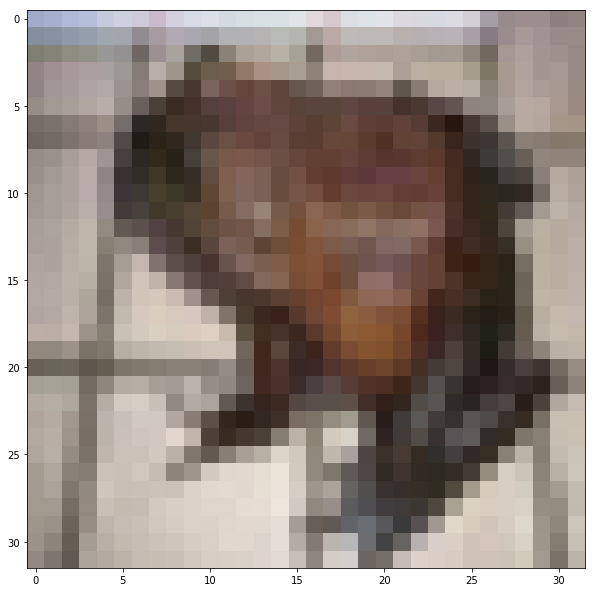

In [12]:
#Chech data generators
gen_data = next(test_generator)
plt.imshow(gen_data[0][1])
print(categories[np.argmax(gen_data[1][1])])

In [13]:
history1 = model1.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = nb_test_samples // batch_size)


Epoch 1/35
1562/1562 [==============================] - 58s - loss: 1.9460 - acc: 0.4391 - val_loss: 1.8477 - val_acc: 0.4270
Epoch 2/35
1562/1562 [==============================] - 58s - loss: 1.5755 - acc: 0.5087 - val_loss: 1.8984 - val_acc: 0.4232
Epoch 3/35
1562/1562 [==============================] - 57s - loss: 1.4605 - acc: 0.5343 - val_loss: 2.0405 - val_acc: 0.4077
Epoch 4/35
1562/1562 [==============================] - 57s - loss: 1.3911 - acc: 0.5554 - val_loss: 1.2843 - val_acc: 0.5877
Epoch 5/35
1562/1562 [==============================] - 57s - loss: 1.3533 - acc: 0.5644 - val_loss: 1.3529 - val_acc: 0.5527
Epoch 6/35
1562/1562 [==============================] - 58s - loss: 1.3265 - acc: 0.5743 - val_loss: 1.2918 - val_acc: 0.5765
Epoch 7/35
1562/1562 [==============================] - 58s - loss: 1.2942 - acc: 0.5855 - val_loss: 1.2583 - val_acc: 0.5949
Epoch 8/35
1562/1562 [==============================] - 58s - loss: 1.2735 - acc: 0.5901 - val_loss: 1.3709 - val_acc:

In [14]:
history2 = model1.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = nb_test_samples // batch_size)

Epoch 1/35
1562/1562 [==============================] - 56s - loss: 1.0103 - acc: 0.6879 - val_loss: 1.2959 - val_acc: 0.5992
Epoch 2/35
1562/1562 [==============================] - 57s - loss: 1.0154 - acc: 0.6858 - val_loss: 1.0260 - val_acc: 0.6818
Epoch 3/35
1562/1562 [==============================] - 56s - loss: 1.0130 - acc: 0.6875 - val_loss: 1.3360 - val_acc: 0.5857
Epoch 4/35
1562/1562 [==============================] - 57s - loss: 1.0100 - acc: 0.6885 - val_loss: 1.0140 - val_acc: 0.6876
Epoch 5/35
1562/1562 [==============================] - 57s - loss: 0.9995 - acc: 0.6901 - val_loss: 1.0432 - val_acc: 0.6834
Epoch 6/35
1562/1562 [==============================] - 56s - loss: 1.0001 - acc: 0.6914 - val_loss: 1.0579 - val_acc: 0.6651
Epoch 7/35
1562/1562 [==============================] - 57s - loss: 0.9927 - acc: 0.6945 - val_loss: 1.1705 - val_acc: 0.6532
Epoch 8/35
1562/1562 [==============================] - 56s - loss: 0.9834 - acc: 0.6979 - val_loss: 0.8733 - val_acc:

In [ ]:
Epoch 1/50
390/390 [==============================] - 39s - loss: 1.8584 - acc: 0.3170 - val_loss: 1.5811 - val_acc: 0.4217
Epoch 2/50
390/390 [==============================] - 38s - loss: 1.5674 - acc: 0.4290 - val_loss: 1.3067 - val_acc: 0.5248
Epoch 3/50
390/390 [==============================] - 39s - loss: 1.4388 - acc: 0.4806 - val_loss: 1.1817 - val_acc: 0.5900
Epoch 4/50
390/390 [==============================] - 39s - loss: 1.3522 - acc: 0.5176 - val_loss: 1.0862 - val_acc: 0.6144
Epoch 5/50
390/390 [==============================] - 38s - loss: 1.2856 - acc: 0.5443 - val_loss: 1.0279 - val_acc: 0.6388
Epoch 6/50
390/390 [==============================] - 39s - loss: 1.2428 - acc: 0.5567 - val_loss: 0.9835 - val_acc: 0.6503
Epoch 7/50
390/390 [==============================] - 40s - loss: 1.2060 - acc: 0.5714 - val_loss: 0.9419 - val_acc: 0.6649
Epoch 8/50
390/390 [==============================] - 39s - loss: 1.1782 - acc: 0.5813 - val_loss: 0.9142 - val_acc: 0.6754
Epoch 9/50
390/390 [==============================] - 39s - loss: 1.1541 - acc: 0.5903 - val_loss: 0.9800 - val_acc: 0.6600
Epoch 10/50
390/390 [==============================] - 39s - loss: 1.1318 - acc: 0.5998 - val_loss: 0.9110 - val_acc: 0.6793
Epoch 11/50
390/390 [==============================] - 38s - loss: 1.1171 - acc: 0.6053 - val_loss: 0.9140 - val_acc: 0.6731
Epoch 12/50
390/390 [==============================] - 38s - loss: 1.1112 - acc: 0.6081 - val_loss: 0.9307 - val_acc: 0.6718
Epoch 13/50
390/390 [==============================] - 38s - loss: 1.0979 - acc: 0.6158 - val_loss: 0.7996 - val_acc: 0.7201
Epoch 14/50
390/390 [==============================] - 38s - loss: 1.0845 - acc: 0.6219 - val_loss: 0.8366 - val_acc: 0.7089
Epoch 15/50
390/390 [==============================] - 38s - loss: 1.0721 - acc: 0.6284 - val_loss: 0.8764 - val_acc: 0.6936
Epoch 16/50
390/390 [==============================] - 38s - loss: 1.0736 - acc: 0.6244 - val_loss: 0.9092 - val_acc: 0.6894
Epoch 17/50
390/390 [==============================] - 38s - loss: 1.0558 - acc: 0.6323 - val_loss: 0.9152 - val_acc: 0.6940
Epoch 18/50
390/390 [==============================] - 39s - loss: 1.0588 - acc: 0.6324 - val_loss: 0.8212 - val_acc: 0.7143
Epoch 19/50
390/390 [==============================] - 38s - loss: 1.0589 - acc: 0.6332 - val_loss: 0.7814 - val_acc: 0.7303
Epoch 20/50
390/390 [==============================] - 39s - loss: 1.0434 - acc: 0.6368 - val_loss: 0.8396 - val_acc: 0.7182
Epoch 21/50
390/390 [==============================] - 39s - loss: 1.0424 - acc: 0.6375 - val_loss: 0.7533 - val_acc: 0.7364
Epoch 22/50
390/390 [==============================] - 39s - loss: 1.0469 - acc: 0.6377 - val_loss: 0.7786 - val_acc: 0.7301
Epoch 23/50
390/390 [==============================] - 38s - loss: 1.0411 - acc: 0.6387 - val_loss: 0.8021 - val_acc: 0.7239
Epoch 24/50
390/390 [==============================] - 38s - loss: 1.0415 - acc: 0.6384 - val_loss: 0.8514 - val_acc: 0.7142
Epoch 25/50
390/390 [==============================] - 39s - loss: 1.0416 - acc: 0.6411 - val_loss: 0.8121 - val_acc: 0.7222
Epoch 26/50
390/390 [==============================] - 38s - loss: 1.0298 - acc: 0.6457 - val_loss: 0.7915 - val_acc: 0.7268
Epoch 27/50
390/390 [==============================] - 38s - loss: 1.0303 - acc: 0.6407 - val_loss: 0.7368 - val_acc: 0.7454
Epoch 28/50
390/390 [==============================] - 38s - loss: 1.0287 - acc: 0.6457 - val_loss: 0.7868 - val_acc: 0.7278
Epoch 29/50
390/390 [==============================] - 38s - loss: 1.0245 - acc: 0.6461 - val_loss: 0.9133 - val_acc: 0.7059
Epoch 30/50
390/390 [==============================] - 38s - loss: 1.0377 - acc: 0.6411 - val_loss: 0.7983 - val_acc: 0.7264
Epoch 31/50
390/390 [==============================] - 38s - loss: 1.0198 - acc: 0.6462 - val_loss: 0.7297 - val_acc: 0.7486
Epoch 32/50
390/390 [==============================] - 38s - loss: 1.0320 - acc: 0.6443 - val_loss: 0.7498 - val_acc: 0.7447
Epoch 33/50
390/390 [==============================] - 38s - loss: 1.0143 - acc: 0.6513 - val_loss: 0.8098 - val_acc: 0.7200
Epoch 34/50
390/390 [==============================] - 39s - loss: 1.0209 - acc: 0.6500 - val_loss: 0.8091 - val_acc: 0.7213
Epoch 35/50
390/390 [==============================] - 38s - loss: 1.0255 - acc: 0.6484 - val_loss: 0.7660 - val_acc: 0.7414
Epoch 36/50
390/390 [==============================] - 38s - loss: 1.0215 - acc: 0.6475 - val_loss: 0.7535 - val_acc: 0.7430
Epoch 37/50
390/390 [==============================] - 38s - loss: 1.0210 - acc: 0.6504 - val_loss: 0.7637 - val_acc: 0.7386
Epoch 38/50
390/390 [==============================] - 38s - loss: 1.0119 - acc: 0.6519 - val_loss: 0.9143 - val_acc: 0.6985
Epoch 39/50
390/390 [==============================] - 38s - loss: 1.0199 - acc: 0.6540 - val_loss: 0.7379 - val_acc: 0.7442
Epoch 40/50
390/390 [==============================] - 38s - loss: 1.0182 - acc: 0.6484 - val_loss: 0.7890 - val_acc: 0.7297
Epoch 41/50
390/390 [==============================] - 38s - loss: 1.0127 - acc: 0.6493 - val_loss: 0.8440 - val_acc: 0.7264
Epoch 42/50
390/390 [==============================] - 39s - loss: 1.0118 - acc: 0.6526 - val_loss: 0.8848 - val_acc: 0.7068
Epoch 43/50
390/390 [==============================] - 38s - loss: 1.0131 - acc: 0.6532 - val_loss: 0.8198 - val_acc: 0.7176
Epoch 44/50
390/390 [==============================] - 39s - loss: 1.0263 - acc: 0.6468 - val_loss: 0.7689 - val_acc: 0.7427
Epoch 45/50
390/390 [==============================] - 38s - loss: 1.0221 - acc: 0.6483 - val_loss: 0.7448 - val_acc: 0.7444
Epoch 46/50
390/390 [==============================] - 38s - loss: 1.0179 - acc: 0.6519 - val_loss: 0.8180 - val_acc: 0.7214
Epoch 47/50
390/390 [==============================] - 38s - loss: 1.0179 - acc: 0.6561 - val_loss: 0.7368 - val_acc: 0.7484
Epoch 48/50
390/390 [==============================] - 38s - loss: 1.0142 - acc: 0.6536 - val_loss: 0.8381 - val_acc: 0.7183
Epoch 49/50
390/390 [==============================] - 38s - loss: 1.0116 - acc: 0.6546 - val_loss: 0.7914 - val_acc: 0.7294
Epoch 50/50
390/390 [==============================] - 38s - loss: 1.0178 - acc: 0.6508 - val_loss: 0.8406 - val_acc: 0.7194

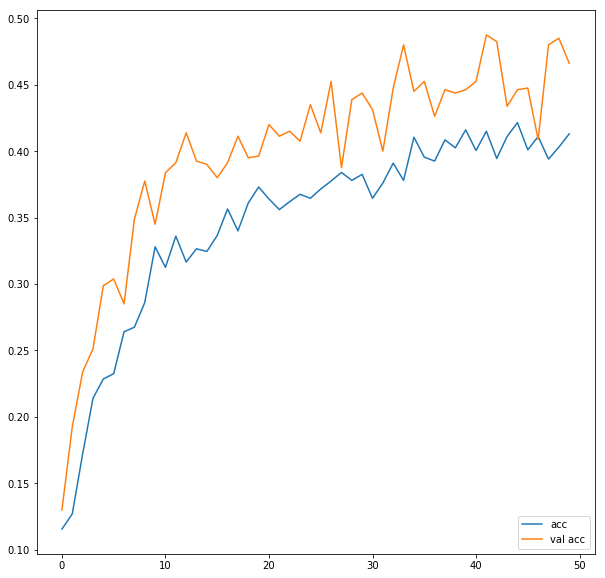

In [15]:
# Plot history
plt.rcParams['figure.figsize'] = (10, 10)        # size of images

plt.plot(history1.history['acc'], label='acc')
plt.plot(history1.history['val_acc'], label='val acc')
plt.legend(loc='lower right')
plt.show()